In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fim import apriori as fim_apriori
from gsp import apriori as gsp_apriori

# Task 4: Frequent Pattern mining and Association Rule Mining

In [2]:
df_geo = pd.read_csv('../geography.csv', sep=',', index_col=0)
df_ram = pd.read_csv('../ram.csv', sep=',', index_col=0)

# Processed dataset split for VCS purposes
df_sales_part1 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part1.csv', sep=',', index_col=0) #The dataset doesn't have a column name. This causes the error.
df_sales_part2 = pd.read_csv('../DM_14_TASK1/task1-df_sales-part2.csv', sep=',', index_col=0)
df_sales = df_sales_part1.append(df_sales_part2)

df_time = pd.read_csv('../time.csv', sep=',', index_col=0)
df_vendor = pd.read_csv('../vendor.csv', sep=',', index_col=0)

/home/avenger/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_sales_merged = df_sales[["Id", "ram_code"]].join(df_ram, on="ram_code", rsuffix="_ram")
df_sales_merged["time_code"] = df_sales["time_code"]
df_sales_merged = df_sales_merged.join(df_time.set_index("time_code"), on="time_code")
df_sales_merged["geo_code"] = df_sales["geo_code"]
df_sales_merged = df_sales_merged.join(df_geo.set_index("geo_code"), on="geo_code")
df_sales_merged["vendor_code"] = df_sales["vendor_code"]
df_sales_merged = df_sales_merged.join(df_vendor.set_index("vendor_code"), on="vendor_code", rsuffix="_vendor")
df_sales_merged = df_sales_merged.join(df_sales[["sales_uds", "sales_currency"]])

In [4]:
df_sales_merged.head()

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
2602347,3719,1.0,ADATA,Adata,0.5,DDR,400,20130322,2013,3,...,12,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.749032,10.65
2602348,3719,1.0,ADATA,Adata,0.5,DDR,400,20130323,2013,3,...,12,18,Europe,Germany,berlin,EUR,32,geizhals_unknown,13.828708,10.65
2602349,3719,1.0,ADATA,Adata,0.5,DDR,400,20130326,2013,3,...,13,28,Europe,Germany,saxony,EUR,32,geizhals_unknown,13.694297,10.65
2602350,3719,1.0,ADATA,Adata,0.5,DDR,400,20130327,2013,3,...,13,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.690530,10.65
2602351,3719,1.0,ADATA,Adata,0.5,DDR,400,20130328,2013,3,...,13,27,Europe,Germany,saarland,EUR,32,geizhals_unknown,13.605216,10.65


## Dataframe pre-processing  
Here we are interested in making the sales dataframe more suitable for our analyses.

### Feature removal

In [5]:
feat_to_drop = ["Id", "time_code", "geo_code", "vendor_code", "sales_currency"]

df_sales_proc = df_sales_merged.drop(feat_to_drop, axis=1)
df_sales_proc.head()

,ram_code,brand,name,memory,memory_type,clock,year,month,day,week,continent,country,region,currency,name_vendor,sales_uds
2602347,1.0,ADATA,Adata,0.5,DDR,400,2013,3,22,12,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,13.749032
2602348,1.0,ADATA,Adata,0.5,DDR,400,2013,3,23,12,Europe,Germany,berlin,EUR,geizhals_unknown,13.828708
2602349,1.0,ADATA,Adata,0.5,DDR,400,2013,3,26,13,Europe,Germany,saxony,EUR,geizhals_unknown,13.694297
2602350,1.0,ADATA,Adata,0.5,DDR,400,2013,3,27,13,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,13.690530
2602351,1.0,ADATA,Adata,0.5,DDR,400,2013,3,28,13,Europe,Germany,saarland,EUR,geizhals_unknown,13.605216


Here we removed some features that are either redundant or do not carry useful information for this task.

### Feature discretisation
We are interested in discretising memory, clock and the sales value using equal-width binning.

#### Memory

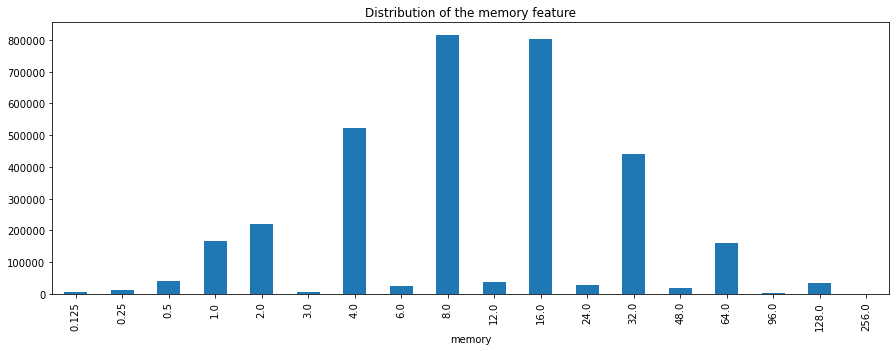

In [6]:
plt.figure(figsize=(15,5))
plt.title("Distribution of the memory feature")
df_sales_proc.groupby("memory").size().plot(kind="bar")
plt.show()

The distribution of memory has an almost symmetric distribution, we can use this to define different bins.  
We will consider the ranges [0,4], [6,8], [12,16], [24,32] and [48,256].  

This choice is in part due to the distribution above and in part based on our knowledge of sizes of ram found in the commercial products.  
In low cost/power/old products usually the amount of ram doesn't exceed 4 GB, mid-range can go up to 8 GB and so on.  
Regarding the last range it reflects the fact that amount of memory is usually used for servers/high-end workstations, therefore they belong to a class of their own.

In [7]:
bins = pd.IntervalIndex.from_tuples([(0, 4), (6, 8), (12, 16), (24, 32), (48, 256)], closed="both")

df_sales_proc.loc[:, "memory"] = pd.cut(df_sales_proc['memory'].astype(int), bins, right=False)
df_sales_proc.loc[:, "memory"] = df_sales_proc["memory"].astype(str) + '_mem'

#### Clock

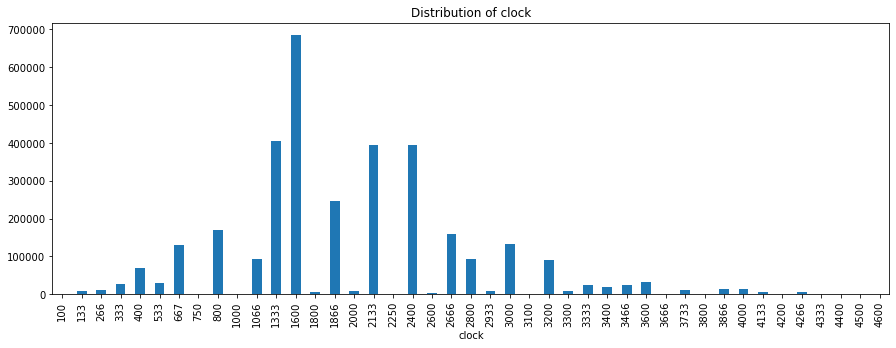

In [8]:
plt.figure(figsize=(15,5))
plt.title("Distribution of clock")
df_sales_proc.groupby(["clock"]).size().plot(kind="bar")
plt.show()

In [9]:
bins = pd.IntervalIndex.from_tuples([(100, 1333), (1600, 1800), (1866, 2250), (2400, 3200), (3300, 4600)], closed="both")

df_sales_proc.loc[:, "clock"] = pd.cut(df_sales_proc['clock'].astype(int), bins, right=False)
df_sales_proc.loc[:, "clock"] = df_sales_proc["clock"].astype(str) + '_clock'

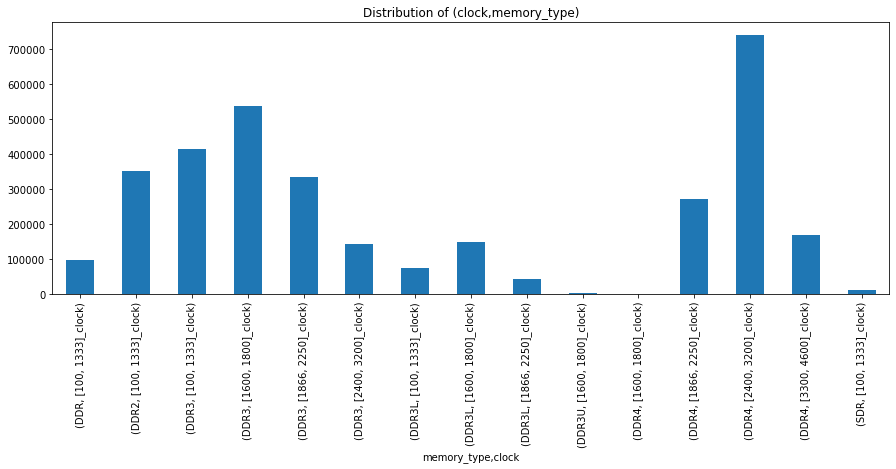

In [10]:
plt.figure(figsize=(15,5))
plt.title("Distribution of (clock,memory_type)")
df_sales_proc.groupby(["memory_type", "clock"]).size().plot(kind="bar")
plt.show()

Again we defined interval roughly based on a equal-frequency binning approach and what can be considered a low-end/high-end product.  
Note that this is only a rough approximation, for the purpouse of discretising we are ignoring the memory_type even though the distribution of the clock is not uniform across the DDR types.

#### Sales

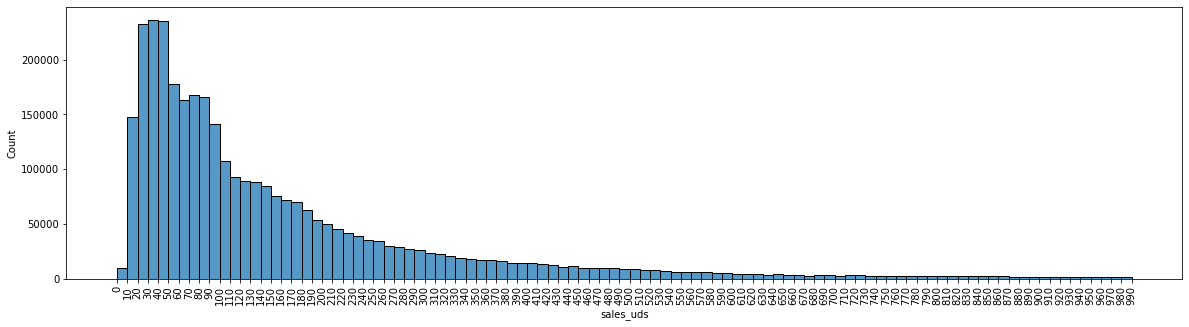

In [11]:
bins = range(0, 1000, 10)

plt.figure(figsize=(20,5))
sn.histplot(df_sales_proc["sales_uds"], bins=bins)
plt.xticks(bins, rotation=90)
plt.show()

In this case we will split the data based on the frequency of the entries using quantiles.

In [12]:
pd.qcut(df_sales_proc["sales_uds"].astype(int), 10).unique()

[(0.999, 27.0], (27.0, 41.0], (41.0, 57.0], (57.0, 78.0], (78.0, 99.0], (99.0, 134.0], (134.0, 177.0], (177.0, 246.0], (246.0, 395.0], (395.0, 10630.0]]
Categories (10, interval[float64]): [(0.999, 27.0] < (27.0, 41.0] < (41.0, 57.0] < (57.0, 78.0] ... (134.0, 177.0] < (177.0, 246.0] < (246.0, 395.0] < (395.0, 10630.0]]

In [13]:
df_sales_proc.loc[:, "sales_uds"] = pd.qcut(df_sales_proc["sales_uds"].astype(int), 10)

df_sales_proc.loc[:, "sales_uds"] = df_sales_proc["sales_uds"].astype(str) + '_sales_uds'

#### Results

In [14]:
df_sales_proc.head()

,ram_code,brand,name,memory,memory_type,clock,year,month,day,week,continent,country,region,currency,name_vendor,sales_uds
2602347,1.0,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013,3,22,12,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602348,1.0,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013,3,23,12,Europe,Germany,berlin,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602349,1.0,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013,3,26,13,Europe,Germany,saxony,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602350,1.0,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013,3,27,13,Europe,Germany,north rhine-westphalla,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
2602351,1.0,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013,3,28,13,Europe,Germany,saarland,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"


## Association rules
Due to memory constraints we are forced to apply an aggressive stratified random sampling to the transactions dataset.

In [265]:
transactions_assoc = df_sales_proc.groupby(["year", "week"]).sample(frac=0.007, random_state=0)
num_trans_assoc = transactions_assoc.shape[0]

print(f"Number of transactions sampled: {num_trans_assoc}")
transactions_assoc.head()

Number of transactions sampled: 23405


,ram_code,brand,name,memory,memory_type,clock,year,month,day,week,continent,country,region,currency,name_vendor,sales_uds
4380352,1451.0,G.SKILL,G.Skill Ripjaws Z,"[24, 32]_mem",DDR3,"[1600, 1800]_clock",2013,3,22,12,Europe,Germany,bremen,EUR,geizhals_unknown,"(177.0, 246.0]_sales_uds"
2606008,3.0,ADATA,Adata,"[0, 4]_mem",DDR,"[100, 1333]_clock",2013,3,23,12,Europe,Germany,rhineland-palatinate,EUR,geizhals_unknown,"(0.999, 27.0]_sales_uds"
3049633,608.0,CORSAIR,Corsair Vengeance,"[6, 8]_mem",DDR3,"[1866, 2250]_clock",2013,3,23,12,Europe,Germany,saxony-anhalt,EUR,geizhals_unknown,"(57.0, 78.0]_sales_uds"
3982202,1224.0,G.SKILL,G.Skill Nq,"[6, 8]_mem",DDR3,"[100, 1333]_clock",2013,3,23,12,Europe,Germany,schleswig-holstein,EUR,geizhals_unknown,"(41.0, 57.0]_sales_uds"
2775407,316.0,AVEXIR,Avexir Blitz,"[0, 4]_mem",DDR3,"[1600, 1800]_clock",2013,3,22,12,Europe,Germany,bremen,EUR,geizhals_unknown,"(27.0, 41.0]_sales_uds"


We sample a fraction of the datapoints from each week of the sales dataframe.

### ram_code-level associations

In [16]:
trans_ram_code = transactions_assoc.groupby(["year", "week"])["ram_code"].apply(list)
trans_ram_code.head()

year  week
2013  12      [1451.0, 3.0, 608.0, 1224.0, 316.0, 1246.0, 98...
      13      [65.0, 1486.0, 1241.0, 2477.0, 1223.0, 605.0, ...
      14      [1287.0, 1438.0, 616.0, 1188.0, 3030.0, 1524.0...
      15      [1704.0, 1745.0, 1465.0, 1447.0, 3379.0, 613.0...
      16      [836.0, 563.0, 1878.0, 1232.0, 2393.0, 1649.0,...
Name: ram_code, dtype: object

In [17]:
baskets_ram = trans_ram_code.values
num_bask_ram = baskets_ram.shape[0]
num_bask_ram

269

In [33]:
rules_ram = fim_apriori(baskets_ram, supp=-4, zmin=2, target='r', conf=60, report='ascl')
print('Number of rules:', len(rules_ram))

Number of rules: 1570582


In [20]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

rules_ram_df = pd.DataFrame(rules_ram, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)

rules_ram_df.head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
4473,1638.0,"(2743.0, 1595.0)",4,0.014870,1.00,67.25
1,832.0,"(967.0, 1400.0)",3,0.011152,0.75,67.25
5,3663.0,"(1363.0, 2199.0, 2185.0)",3,0.011152,0.75,67.25
6,1945.0,"(2491.0, 606.0)",3,0.011152,0.75,67.25
7,82.0,"(2025.0, 1394.0, 660.0, 677.0)",3,0.011152,0.75,67.25
8,82.0,"(2025.0, 1394.0, 660.0)",3,0.011152,0.75,67.25
9,82.0,"(2025.0, 1394.0, 677.0)",3,0.011152,0.75,67.25
10,82.0,"(2025.0, 1394.0)",3,0.011152,0.75,67.25
11,82.0,"(2025.0, 2298.0, 660.0, 677.0)",3,0.011152,0.75,67.25
13,82.0,"(2025.0, 2298.0, 677.0)",3,0.011152,0.75,67.25


In [21]:
df_ram.loc[[1595.0, 2743.0, 1638.0]]

,brand,name,memory,memory_type,clock
ram_code,,,,,
1595.0,G.SKILL,G.Skill Trident Z,16.0,DDR4,3600
2743.0,MUSHKIN,Mushkin Enhanced Proline,4.0,DDR3,1333
1638.0,G.SKILL,G.Skill Trident Z,128.0,DDR4,3466


The support for these rules is very low, even relative to the number of baskets used.  
Trying to find association rules through the sole use of the ram_code doesn't seem to be a fruitful endeavour.

### Dataframe-level associations

In [22]:
report_cols = ["Conseq.", "Prem.", "Support (abs)", "Support (frac)", "Confidence", "Lift"]

In [107]:
def filter_rules(rule_df, filter_func_list):
    
    for idx, row in rule_df.iterrows():
        
        prems = row.loc["Prem."]
        conseqs = row.loc["Conseq."]
        
        for filter_func in filter_func_list:
            if filter_func(prems, conseqs):
                
                rule_df = rule_df.drop(row.name)
                break #Already deleted, no need for further filtering
    
    return rule_df
                
                
def filter_country_continent_curr(prems, conseq):
    #Filters all associations between currency, country and continent
    
    curr_vals = df_geo["currency"].unique()
    country_vals = df_geo["country"].unique()
    contin_vals = df_geo["continent"].unique()
    
    for prem in prems:
        if prem in curr_vals:
            
            if conseq in country_vals or conseq in contin_vals:
                return True
            
        if prem in country_vals or prem in contin_vals:
            
            if conseq in curr_vals:
                return True
            
            if conseq in country_vals or conseq in contin_vals:
                return True
                    
    return False


def filter_brand_ram_name(prems, conseq):
    #Filter associations between brand and brand's product name
    
    brand_vals = df_ram["brand"].unique()
    name_vals = df_ram["name"].unique()
    
    for prem in prems:
        if prem in brand_vals and conseq in name_vals:
            return True
        if prem in name_vals and conseq in brand_vals:
            return True
        
    return False            

A significant percentage of the rules discovered are "obvious" associations, such as "the transactions in country x use the currency of that country".  
In order to filter them out we create some ad-hoc filter rules.

In [263]:
filters = [filter_country_continent_curr, filter_brand_ram_name]

baskets_whole_df = transactions_assoc.drop(["year", "month", "week", "day"], axis=1) #Remove time-related features
baskets_whole = baskets_whole_df.values.tolist()

#Keep only entries with Lift >=2
rules_whole = fim_apriori(baskets_whole, supp=5, zmin=2, target='r', conf=60, report='ascl', eval="l", thresh=200, prune=1)

rules_whole_df = pd.DataFrame(rules_whole, columns=report_cols).sort_values(["Lift", "Support (abs)"], ascending=False)
rules_whole_df_filtered = filter_rules(rules_whole_df, filters)

print('Number of rules:', rules_whole_df_filtered.shape[0])

Number of rules: 25


In order to sift through the rules more easily we used the pruning functionality of the apriori implementation.

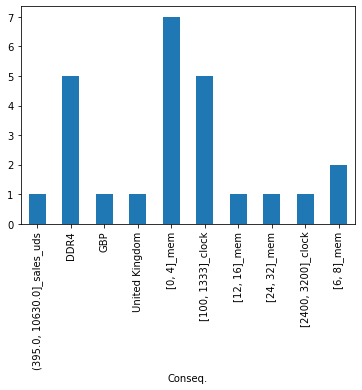

In [264]:
rules_whole_df_filtered.groupby("Conseq.").size().plot(kind="bar")
plt.show()

Here we can see that the majority of the rules have the memory size or clock as consequents.  
We will take a brief look at each consequent in order to see if there is any new information to be had.

In [251]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == '(395.0, 10630.0]_sales_uds'].head()

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
11,"(395.0, 10630.0]_sales_uds","([48, 256]_mem,)",1292,0.055202,0.888583,9.334511


In [240]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."] == 'DDR4'].head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
0,DDR4,"([3300, 4600]_clock,)",1185,0.050630,1.000000,2.854616
35,DDR4,"([2400, 3200]_clock,)",5141,0.219654,0.835527,2.385110
10,DDR4,"([48, 256]_mem, (395.0, 10630.0]_sales_uds)",953,0.040718,0.737616,2.105611
12,DDR4,"([48, 256]_mem,)",1051,0.044905,0.722834,2.063413
18,DDR4,"((395.0, 10630.0]_sales_uds,)",1597,0.068233,0.716786,2.046150


Here the rules roughly point out which are the clock rates, price and memory size associated with DDR4.

In [253]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['United Kingdom', 'GBP'])].head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
16,United Kingdom,"(pricespy_unknown,)",1954,0.083486,0.908837,6.162032
17,GBP,"(pricespy_unknown,)",1954,0.083486,0.908837,6.162032


As we pointed out in task 1, pricespy_unknown is a UK-based price search engine so no surprises here.

In [257]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."]\
                            .isin(['[0, 4]_mem', '[6, 8]_mem', '[12, 16]_mem', '[24, 32]_mem'])].head(15)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
23,"[24, 32]_mem","((246.0, 395.0]_sales_uds,)",1494,0.063833,0.626153,4.481682
29,"[0, 4]_mem","((0.999, 27.0]_sales_uds, [100, 1333]_clock)",1968,0.084085,0.996960,3.353048
32,"[0, 4]_mem","((0.999, 27.0]_sales_uds,)",2528,0.108011,0.996060,3.350019
25,"[0, 4]_mem","(DDR2, [100, 1333]_clock)",2224,0.095022,0.883943,2.972939
28,"[0, 4]_mem","(DDR2,)",2224,0.095022,0.883943,2.972939
19,"[12, 16]_mem","((134.0, 177.0]_sales_uds,)",1663,0.071053,0.727790,2.915769
22,"[0, 4]_mem","((27.0, 41.0]_sales_uds,)",2006,0.085708,0.860206,2.893105
24,"[6, 8]_mem","((57.0, 78.0]_sales_uds,)",1581,0.067550,0.648482,2.581247
21,"[6, 8]_mem","((78.0, 99.0]_sales_uds,)",1439,0.061483,0.625380,2.489290
37,"[0, 4]_mem","([100, 1333]_clock,)",4564,0.195001,0.679369,2.284901


Here we can see the association rules between the memory size and the price/clock/memory type.

In [259]:
rules_whole_df_filtered.loc[rules_whole_df_filtered["Conseq."].isin(['[100, 1333]_clock', '[2400, 3200]_clock'])].head(10)

,Conseq.,Prem.,Support (abs),Support (frac),Confidence,Lift
27,"[100, 1333]_clock","(DDR2,)",2516,0.107498,1.000000,3.483924
26,"[100, 1333]_clock","(DDR2, [0, 4]_mem)",2224,0.095022,1.000000,3.483924
30,"[100, 1333]_clock","((0.999, 27.0]_sales_uds, [0, 4]_mem)",1968,0.084085,0.778481,2.712169
31,"[100, 1333]_clock","((0.999, 27.0]_sales_uds,)",1974,0.084341,0.777778,2.709719
36,"[2400, 3200]_clock","(DDR4,)",5141,0.219654,0.627028,2.385110
38,"[100, 1333]_clock","([0, 4]_mem,)",4564,0.195001,0.655841,2.284901


These are the associations between the clock and the other features.

## Frequent patterns

In [ ]:
baskets = df_sales_merged.reset_index().groupby(["year", "month"]).sample(frac=0.05)
baskets = baskets.groupby(["year", "month"])["index"].apply(list)
baskets

In [ ]:
baskets_exp = baskets.copy()

for row in baskets_exp:
    for i in range(len(row)):
        row[i] = df_sales_merged.loc[df_sales_merged.index==row[i], ["brand", "country"]].values
        
baskets_exp

In [ ]:
result_set = gsp_apriori(baskets_exp, baskets_exp.shape[0]*50//100, verbose=False)

In [ ]:
stophere